In [1]:
from multiprocessing import Pool,sharedctypes
from functools import partial
from contextlib import closing
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import h5py as h5
import os
import sys
import skymapper as skm
import matplotlib.cm as cm
import matplotlib
import copy
from matplotlib.colors import LinearSegmentedColormap

colors = ['#601A4A', '#EE442F','#63ACBE']




from matplotlib import rc
#rc('text', usetex=True)
rc('font', family='serif')
rc('font', size=11)
fontsize='small'


skymapper: survey definitions missing because pymangle is not installed


# Read data

In [4]:
import yaml
import destest
import treecorr


# basic dict props
destest_dict_ = {
    'output_exists' : True,
    'use_mpi'       : False,
    'source'        : 'hdf5',
    'dg'            : 0.01
    }

# Populates a full destest yaml dict for each catalog selection based on the limited catalog input info provided in the common cats.yaml file
def create_destest_yaml( params, name, cal_type, group, table, select_path ):
    """
    Creates the input dictionary structure from a passed dictionary rather than reading froma yaml file.
    """

    destest_dict = destest_dict_.copy()
    destest_dict['load_cache'] = params['load_cache']
    destest_dict['output'] = params['output']
    destest_dict['name'] = name
    destest_dict['filename'] = params['datafile']
    destest_dict['param_file'] = params['param_file']
    destest_dict['cal_type'] = cal_type
    destest_dict['group'] = group
    destest_dict['table'] = table
    destest_dict['select_path'] = select_path
    destest_dict['e'] = ['e_1','e_2']
    destest_dict['Rg'] = ['R11','R22']
    destest_dict['w'] = 'weight'

    return destest_dict

# Build selector (and calibrator) classes from destest for the catalog.
def load_catalog(pipe_params, name, cal_type, group, table, select_path, inherit=None, return_calibrator=None):
    """
    Loads data access and calibration classes from destest for a given yaml setup file.
    """

    # Input yaml file defining catalog
    params = create_destest_yaml(pipe_params, name, cal_type, group, table, select_path)

    # Load destest source class to manage access to file
    source = destest.H5Source(params)

    # Load destest selector class to manage access to data in a structured way
    if inherit is None:
        sel = destest.Selector(params,source)
    else:
        sel = destest.Selector(params,source,inherit=inherit)

    # Load destest calibrator class to manage calibration of the catalog
    if return_calibrator is not None:
        cal = return_calibrator(params,sel)
        return sel, cal
    else:
        return sel

# Read yaml file that defines all the catalog selections used
params = yaml.load(open('/home/supriyo/dp1/gatti/Y3_shearcat_tests/Maps/cats.yaml'),Loader=yaml.SafeLoader)
params['param_file'] = 'cats.yaml'

# Source catalog
source_selector, source_calibrator = load_catalog(
    params, 'mcal', 'mcal', params['source_group'], params['source_table'], params['source_path'], return_calibrator=destest.MetaCalib)

# Gold catalog
gold_selector = load_catalog(
    params, 'gold', 'mcal', params['gold_group'], params['gold_table'], params['gold_path'], inherit=source_selector)
# BPZ (or DNF) catalog, depending on paths in cats.yaml file (exchange bpz and dnf)
pz_selector = load_catalog(
    params, 'pz', 'mcal', params['pz_group'], params['pz_table'], params['pz_path'], inherit=source_selector)


R1,c,w = source_calibrator.calibrate('e_1') # Optionally pass an additional mask to use when calculating the selection response. The returned R1 is <Rg_1 + Rs_1>. To get an array of R's, use return_wRg=True to get [Rg_1+Rg_2]/2 for each object or return_wRgS=True to include the selection response. return_full=True returns the non-component-averaged version of the full response.
print(R1,c,w)
R2,c,w = source_calibrator.calibrate('e_2')
print(R2,c,w)


# Load ra,dec from gold catalog
ra  = gold_selector.get_col('ra')[0]
dec = gold_selector.get_col('dec')[0]


ra1  = source_selector.get_col('ra')[0]
dec1 = source_selector.get_col('dec')[0]

# Get e1,e2 
g1=source_selector.get_col('e_1')[0]
g2=source_selector.get_col('e_2')[0]
snr =source_selector.get_col('snr')[0]
size_ratio =source_selector.get_col('size_ratio')[0]
w = source_calibrator.calibrate('e_1',weight_only=True) # Optionally pass an additional mask to use when calculating the selection response. The returned R1 is <Rg_1 + Rs_1>. To get an array of R's, use return_wRg=True to get [Rg_1+Rg_2]/2 for each object or return_wRgS=True to include the selection response. return_full=True returns the non-component-averaged version of the full response.
R_array = source_calibrator.calibrate('e_1',return_wRgS=True)

g1 =(g1 - np.mean(g1*w)/np.mean(w))/R1
g2 =(g2 - np.mean(g2*w)/np.mean(w))/R2


['T', 'T_err', 'covmat_0_1', 'covmat_1_1', 'covmat_2_2', 'e_1', 'e_2', 'flux_err_i', 'flux_err_r', 'flux_err_z', 'flux_i', 'flux_r', 'flux_z', 'size_ratio', 'snr', 'weight']
using select_path for mask
destest /home/supriyo/dp1/ALL_DATA/DESY3_indexcat.h5 index/select 399263026 100204026
end mask [     7390      7391      7393 ... 399243228 399243235 399243240] [ True  True  True ...  True  True  True]
R11 not in sheared cols
R11 not in sheared cols
R11 not in sheared cols
R11 not in sheared cols
R22 not in sheared cols
R22 not in sheared cols
R22 not in sheared cols
R22 not in sheared cols
skipping sheared columns for e_1
skipping sheared columns for e_1
skipping sheared columns for e_1
skipping sheared columns for e_1
skipping sheared columns for e_2
skipping sheared columns for e_2
skipping sheared columns for e_2
skipping sheared columns for e_2
['bhat', 'cell_wide']
----- e_1 ['e_1', 'e_2']
Rs e_1 0.6735345059634048 0.008888230810601904
0.7175082070835618 0.0 [32.7504844  41.1602656

In [2]:
import pickle
with open('/Users/supriyosaha/Desktop/DP1/shear_data.pkl', 'rb') as f:
    ra,dec,R1,R2,g1, g2, snr, size_ratio, w, R_array = pickle.load(f)

In [3]:
g1 =(g1 - np.mean(g1*w)/np.mean(w))/R1
g2 =(g2 - np.mean(g2*w)/np.mean(w))/R2

# create maps

In [4]:
nside=1024
import healpy as hp

def convert_to_pix_coord(ra, dec, nside):
    """
    Converts right ascension (ra) and declination (dec) to Healpix pixel indices.
    
    Parameters:
    ra : array-like
        Right ascension in degrees.
    dec : array-like
        Declination in degrees.
    nside : int
        The Healpix nside parameter, which defines the resolution of the map.
        
    Returns:
    pix : array-like
        The Healpix pixel indices corresponding to the input coordinates.
    """
    # Convert ra, dec to radians
    theta = np.radians(90 - dec)
    phi = np.radians(ra)
    
    # Use healpy to get the pixel indices
    pix = hp.ang2pix(nside, theta, phi)
    
    return pix


In [6]:
desy3_map = np.zeros(hp.nside2npix(nside))
desy3_map_w = np.zeros(hp.nside2npix(nside))
desy3_map_w2 = np.zeros(hp.nside2npix(nside))
w_map = np.zeros(hp.nside2npix(nside))
snr_map = np.zeros(hp.nside2npix(nside))
snr_map_w = np.zeros(hp.nside2npix(nside))
SR_map = np.zeros(hp.nside2npix(nside))
SR_map_w = np.zeros(hp.nside2npix(nside))
response_map_w = np.zeros(hp.nside2npix(nside))

sum_we2_2 = np.zeros(hp.nside2npix(nside))
sum_we2_1 = np.zeros(hp.nside2npix(nside))
sum_w2 = np.zeros(hp.nside2npix(nside))
sum_w = np.zeros(hp.nside2npix(nside))
e1_map = np.zeros(hp.nside2npix(nside))
e1_map_w = np.zeros(hp.nside2npix(nside))
e2_map = np.zeros(hp.nside2npix(nside))
e2_map_w = np.zeros(hp.nside2npix(nside))


pix1 = convert_to_pix_coord(ra,dec, nside=nside)
unique_pix1, idx1, idx_rep1 = np.unique(pix1, return_index=True, return_inverse=True)


desy3_map[unique_pix1] += np.bincount(idx_rep1, weights=np.ones(len(pix1)))
desy3_map_w[unique_pix1] += np.bincount(idx_rep1, weights=w)
desy3_map_w2[unique_pix1] += np.bincount(idx_rep1, weights=w**2)
w_map[unique_pix1] += np.bincount(idx_rep1, weights=w)
snr_map_w[unique_pix1] += np.bincount(idx_rep1, weights=snr*w)
snr_map[unique_pix1] += np.bincount(idx_rep1, weights=snr)
SR_map[unique_pix1] += np.bincount(idx_rep1, weights=size_ratio)
SR_map_w [unique_pix1] += np.bincount(idx_rep1, weights=(size_ratio*w))
sum_we2_2[unique_pix1] += np.bincount(idx_rep1, weights=(w*g2)**2)
sum_we2_1[unique_pix1] += np.bincount(idx_rep1, weights=(w*g1)**2)
sum_w2[unique_pix1] += np.bincount(idx_rep1, weights=(w)**2)
sum_w[unique_pix1] += np.bincount(idx_rep1, weights=(w))
response_map_w[unique_pix1] += np.bincount(idx_rep1, weights=R_array)

e1_map_w[unique_pix1] += np.bincount(idx_rep1, weights=g1*w)
e2_map_w[unique_pix1] += np.bincount(idx_rep1, weights=g2*w)
e1_map[unique_pix1] += np.bincount(idx_rep1, weights=g1)
e2_map[unique_pix1] += np.bincount(idx_rep1, weights=g2)


mas_desy3 = desy3_map!=0.
n_eff = desy3_map/(hp.pixelfunc.nside2pixarea(nside,degrees=True)*(60*60)) #/R_ave
n_eff_w = desy3_map_w**2/desy3_map_w2/(hp.pixelfunc.nside2pixarea(nside,degrees=True)*(60*60)) #/R_ave
w_map[mas_desy3] = w_map[mas_desy3]/desy3_map[mas_desy3]
snr_map[mas_desy3] = snr_map[mas_desy3]/desy3_map[mas_desy3]
snr_map_w[mas_desy3] = snr_map_w[mas_desy3]/desy3_map_w[mas_desy3]
SR_map[mas_desy3] = SR_map[mas_desy3]/desy3_map[mas_desy3]
SR_map_w[mas_desy3] = SR_map_w[mas_desy3]/desy3_map_w[mas_desy3]
response_map_w[mas_desy3]=response_map_w[mas_desy3]/desy3_map_w[mas_desy3]
sig_e = np.sqrt((sum_we2_1/sum_w**2+sum_we2_2/sum_w**2)*(sum_w**2/sum_w2)/2.)
e1_map_w[mas_desy3]=e1_map_w[mas_desy3]/desy3_map_w[mas_desy3]
e2_map_w[mas_desy3]=e2_map_w[mas_desy3]/desy3_map_w[mas_desy3]
e1_map[mas_desy3]  =e1_map[mas_desy3]/desy3_map[mas_desy3]
e2_map[mas_desy3]  =e2_map[mas_desy3]/desy3_map[mas_desy3]



dict_maps = dict()
dict_maps['e2_map']=e2_map
dict_maps['e1_map']=e1_map
dict_maps['e1_map_w']=e1_map_w
dict_maps['e2_map_w']=e2_map_w
dict_maps['sig_e']=sig_e
dict_maps['response_map_w']=response_map_w
dict_maps['SR_map_w']=SR_map_w
dict_maps['SR_map']=SR_map
dict_maps['w_map']=w_map
dict_maps['snr_map_w']=snr_map_w
dict_maps['snr_map']=snr_map
dict_maps['n_eff_w']=n_eff_w
dict_maps['n_eff']=n_eff
dict_maps['mas_desy3']=mas_desy3
import pickle
def save_obj( name,obj ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

save_obj('dict_maps',dict_maps)


/var/folders/5_/3zgtm4ks70x91wzj2r9lc_qc0000gn/T/ipykernel_11833/1533106484.py:47: RuntimeWarning: invalid value encountered in divide
  n_eff_w = desy3_map_w**2/desy3_map_w2/(hp.pixelfunc.nside2pixarea(nside,degrees=True)*(60*60)) #/R_ave
/var/folders/5_/3zgtm4ks70x91wzj2r9lc_qc0000gn/T/ipykernel_11833/1533106484.py:54: RuntimeWarning: invalid value encountered in divide
  sig_e = np.sqrt((sum_we2_1/sum_w**2+sum_we2_2/sum_w**2)*(sum_w**2/sum_w2)/2.)


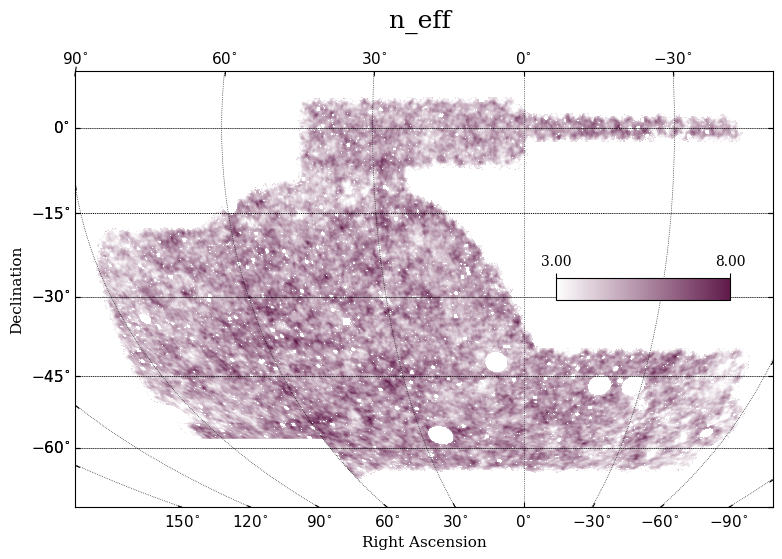

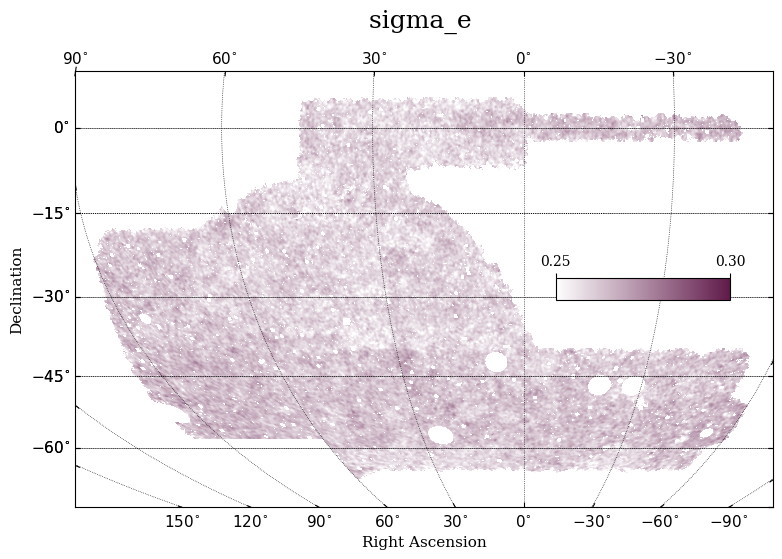

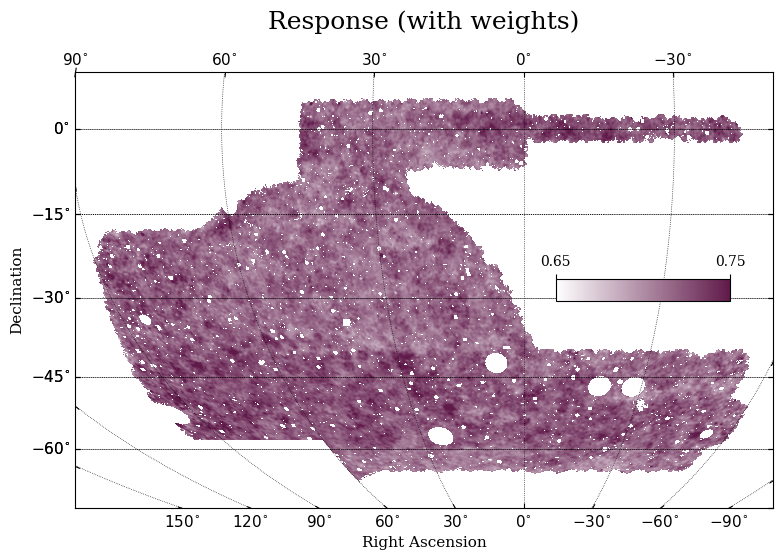

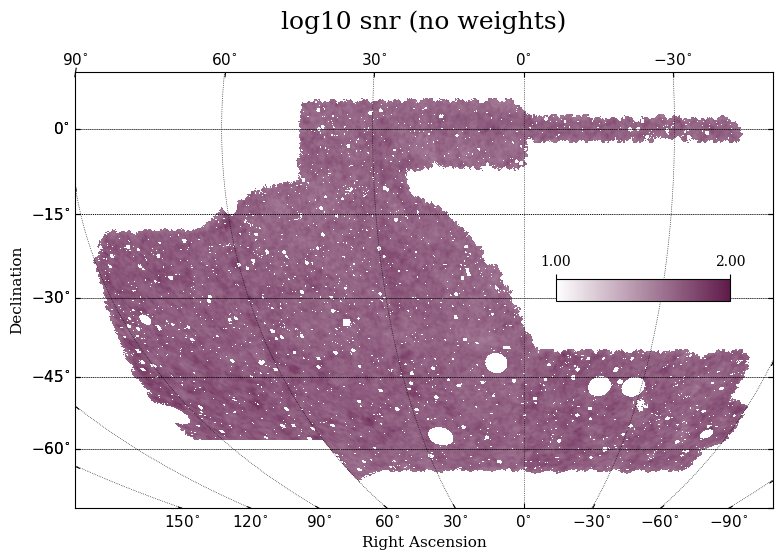

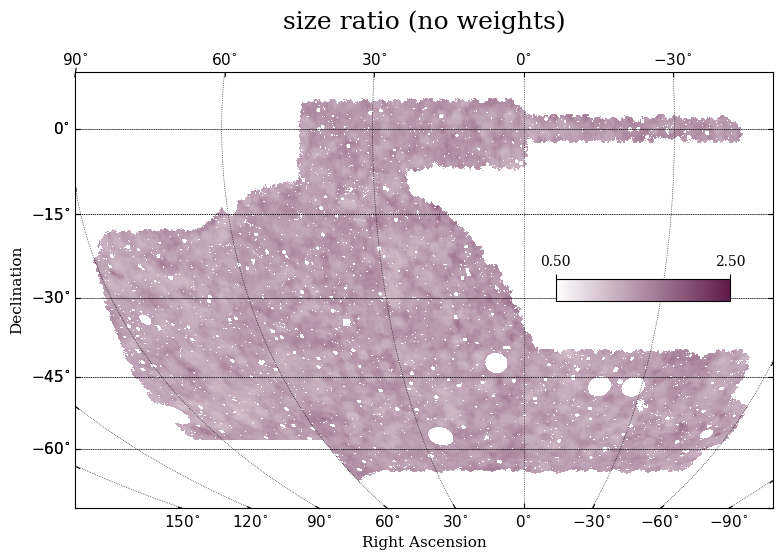

In [9]:

import os
os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"
import pylab as plt
import skymap
from skymap import Skymap,McBrydeSkymap,OrthoSkymap

import healpy as hp
import fitsio
import numpy as np
import skymap
from skymap.survey import DESSkymap
import sys
import pickle



nside=1024


import pickle
colors = ['#601A4A', '#EE442F','#63ACBE']

from matplotlib.colors import LinearSegmentedColormap


def load_obj(name):
    
        try:
            with open(name + '.pkl', 'rb') as f:
                return pickle.load(f)#, encoding='latin1')
        except:
            with open(name + '.pkl', 'rb') as f:
                return pickle.load(f, encoding='latin1')
            
            
def make_plot(mapp,pix_mask,savedir,title,xsize=5000,smooth=10.0/60,smoothing=True,vmin=-0.01,vmax=0.01):
    fig = plt.figure(figsize=(9,6))


    smap = skymap.DESSkymap()
    ax=plt.gca()
    

    
    plt.sca(ax)
    if smoothing:
        smap.draw_hpxmap(mapp[pix_mask],pix_mask,nside,cmap=cmap,vmin=vmin,vmax=vmax,xsize=xsize,smooth=smooth) #
    else:
        smap.draw_hpxmap(mapp[pix_mask],pix_mask,nside,cmap=cmap,vmin=vmin,vmax=vmax,xsize=xsize) #
    smap.draw_inset_colorbar(ticks=[vmin,vmax],format='%.2f',fontsize=10,bbox_to_anchor=(-0.05,-0.0,1,1))
    
    plt.title(title,y=1.08,fontsize=18)
    #plt.savefig(savedir,bbox_inches='tight')
    plt.show()

des_c1_cmap = LinearSegmentedColormap.from_list('mycmap', list(zip(np.linspace(0,1,2), ['#ffffff', colors[0]])))

cmap = des_c1_cmap

dictt=load_obj('dict_maps')
pixels = np.arange(hp.nside2npix(nside))
pix_mask =pixels[dictt['mas_desy3']]


make_plot((dictt['n_eff_w']), pix_mask, title='n_eff ', vmin=3., vmax=8., savedir='/home/supriyo/dp1/gatti/Y3_shearcat_tests/Maps/neffw.pdf')
make_plot((dictt['sig_e']), pix_mask, title='sigma_e ', vmin=0.25, vmax=0.3, savedir='/home/supriyo/dp1/gatti/Y3_shearcat_tests/Maps/sige.pdf')
make_plot((dictt['response_map_w']), pix_mask, title='Response (with weights)', vmin=0.65, vmax=0.75, savedir='/home/supriyo/dp1/gatti/Y3_shearcat_tests/Maps/responsew.pdf')
make_plot(np.log10(dictt['snr_map'] + 1), pix_mask, title='log10 snr (no weights)', vmin=1., vmax=2, savedir='/home/supriyo/dp1/gatti/Y3_shearcat_tests/Maps/snr.pdf')
make_plot((dictt['SR_map']), pix_mask, title='size ratio (no weights)', vmin=0.5, vmax=2.5, savedir='/home/supriyo/dp1/gatti/Y3_shearcat_tests/Maps/SR.pdf')




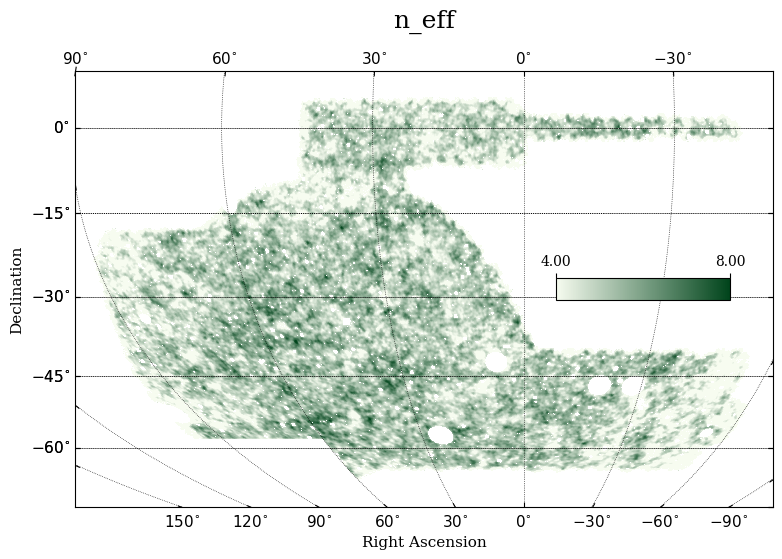

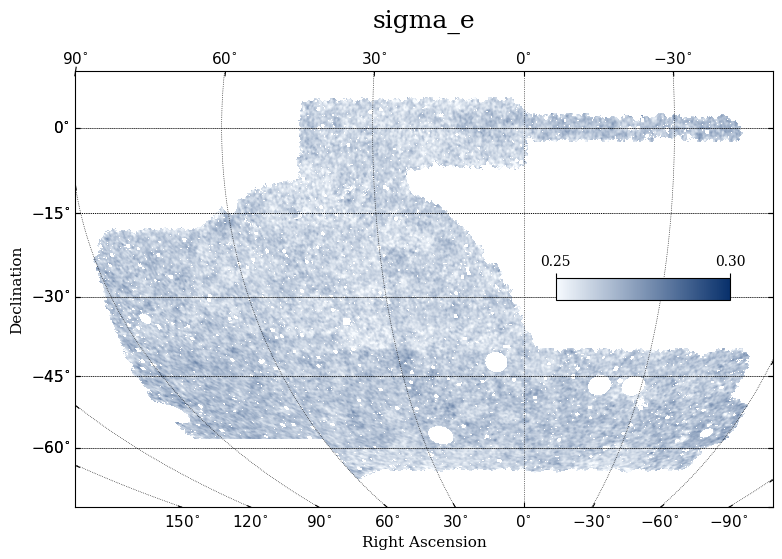

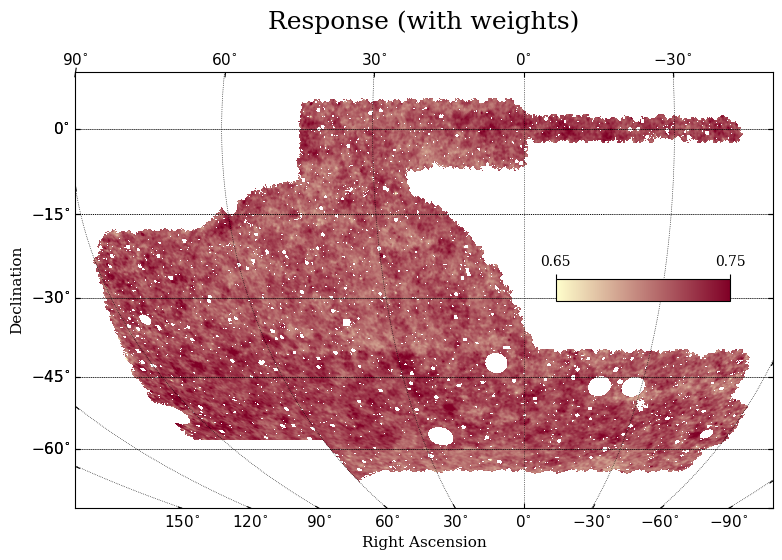

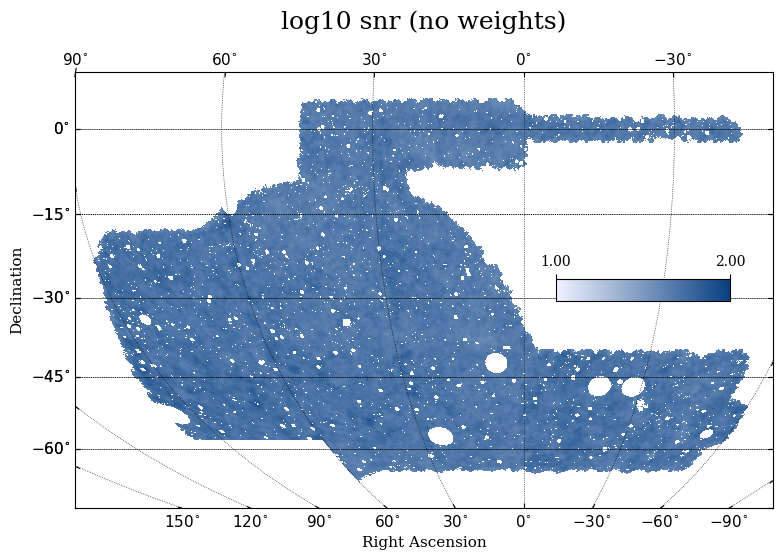

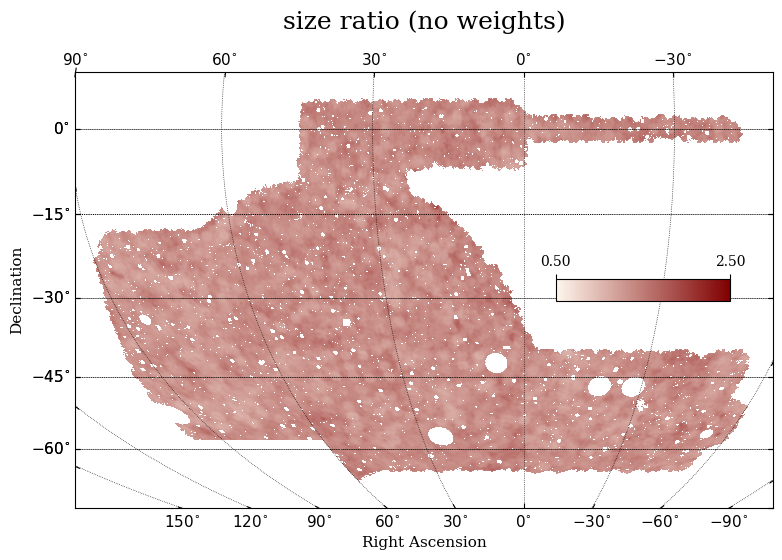

In [12]:
# Define individual color maps for each plot
cmap_neff = LinearSegmentedColormap.from_list('cmap_neff', ['#f7fcf0', '#00441b'])
cmap_sige = LinearSegmentedColormap.from_list('cmap_sige', ['#f7fbff', '#08306b'])
cmap_response = LinearSegmentedColormap.from_list('cmap_response', ['#ffffcc', '#800026'])
cmap_snr = LinearSegmentedColormap.from_list('cmap_snr', ['#f0f3ff', '#084081'])
cmap_sr = LinearSegmentedColormap.from_list('cmap_sr', ['#fff7ec', '#7f0000'])

# Function to generate plots with customizable color maps
def make_plot(mapp, pix_mask, title, cmap, xsize=5000, smooth=10.0/60, smoothing=True, vmin=-0.01, vmax=0.01):
    fig = plt.figure(figsize=(9, 6))
    smap = skymap.DESSkymap()
    ax = plt.gca()
    plt.sca(ax)
    if smoothing:
        smap.draw_hpxmap(mapp[pix_mask], pix_mask, nside, cmap=cmap, vmin=vmin, vmax=vmax, xsize=xsize, smooth=smooth)
    else:
        smap.draw_hpxmap(mapp[pix_mask], pix_mask, nside, cmap=cmap, vmin=vmin, vmax=vmax, xsize=xsize)
    smap.draw_inset_colorbar(ticks=[vmin, vmax], format='%.2f', fontsize=10, bbox_to_anchor=(-0.05, -0.0, 1, 1))
    plt.title(title, y=1.08, fontsize=18)
    # Uncomment the following line to save the plot
    # plt.savefig(f"{title.replace(' ', '_')}.pdf", bbox_inches='tight')
    plt.show()

# Load the dictionary
dictt = load_obj('dict_maps')
pixels = np.arange(hp.nside2npix(nside))
pix_mask = pixels[dictt['mas_desy3']]

# Create and display plots with different color maps
make_plot(dictt['n_eff_w'], pix_mask, title='n_eff', cmap=cmap_neff, vmin=4., vmax=8.)
make_plot(dictt['sig_e'], pix_mask, title='sigma_e', cmap=cmap_sige, vmin=0.25, vmax=0.3)
make_plot(dictt['response_map_w'], pix_mask, title='Response (with weights)', cmap=cmap_response, vmin=0.65, vmax=0.75)
make_plot(np.log10(dictt['snr_map'] + 1), pix_mask, title='log10 snr (no weights)', cmap=cmap_snr, vmin=1., vmax=2.)
make_plot(dictt['SR_map'], pix_mask, title='size ratio (no weights)', cmap=cmap_sr, vmin=0.5, vmax=2.5)


In [ ]:
def apply_random_rotation(e1_in, e2_in):
    np.random.seed() # CRITICAL in multiple processes !
    rot_angle = np.random.rand(len(e1_in))*2*np.pi #no need for 2?
    cos = np.cos(rot_angle)
    sin = np.sin(rot_angle)
    e1_out = + e1_in * cos + e2_in * sin
    e2_out = - e1_in * sin + e2_in * cos
    return e1_out, e2_out


e1_out, e2_out = apply_random_rotation(g1, g2)